# SimplePreprocessor

Here we demonstrate a class for tokenization and lemmatization that offers:

- Good tokenization of abbreviations, numbers and punctuation, in addition to normal words.
- Fairly fast tokenization and lemmatization.
- A stop word list designed for the tool's default output.
- Acceptable, if not perfect, lemmatization of nouns and some verb forms.

## Notes on lemmatization

DocPreprocessor uses NLTK's WordNetLemmatizer. The [TokensLemmasStopwords](./TokensLemmasStopwords.ipynb) notebook explores this lemmatizer in detail, and finds it deficient for a number of reasons. I have decided to use it here solely on the basis of runtime&mdash;the only other option I have worked with being the much slower Spacy lemmatizer, which requires a full parse. (Spacy's lemmatizer is compared head-to-head in the TokensLemmasStopwords notebook.)

It is worth doubting whether lemmatization is worth the additional runtime cost. See [Camacho-Collados & Pilehvar (2018)](https://arxiv.org/pdf/1707.01780.pdf) for a good start into exploring this issue as it applies to deep learning. More generally, [Ganesan 2019](https://www.kdnuggets.com/2019/04/text-preprocessing-nlp-machine-learning.html) may be of some use, especially on the point of taking into consideration the size and noisiness of your data.

## Stop words

We start with the stop word list because that is a SimplePreprocessor dependency.

SimplePreprocessor's stop word list has been tailored for SimplePreprocessor&mdash;for its tokenizer, to be precise. It is obvious why one's stop word list needs to match the output of one's tokenizer. In practice, however, this is often not the case. For example, the [sklearn documentation for CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) gives a warning about that class's default stop word list: 

> There are several known issues with ‘english’ and you should consider an alternative (see [Using stop words](https://scikit-learn.org/stable/modules/feature_extraction.html#stop-words)).

The *Using stop words* link on that sklearn page also warns:

>You should also make sure that the stop word list has had the same preprocessing and tokenization applied as the one used in the vectorizer. The word *we’ve* is split into we and ve by CountVectorizer’s default tokenizer, so if *we’ve* is in stop_words, but *ve* is not, *ve* will be retained from *we’ve* in transformed text.

There are at least two ways that an application's stop word list might not match the output of its tokenizer:

- Developers "borrow" a freely-available stop word list without paying much attention to its elements.
- Developers start with a stop word list in synch with their tokenizer, but the two become out-of-synch during the course of development.

Rather than simply create a list of stop words whose provenance and rationale will eventually be forgotten, I decided to write a function that generates stop words. Each step in the process is documented. This will, I hope, help prevent the contents of the stop word list from being forgotten, and make it easy to keep the stop words in synch with the SimplePreprocessor tokenizer as development continues.

In [1]:
from spacy.lang.en.stop_words import STOP_WORDS as SpacyStopWords
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS as SklearnStopWords

def generateStopWords():
    """
    Generate stopwords, following a pre-determined routine. 
    :return: a set of strings
    """
    # Start with intersection of Spacy and sklearn stop word lists.
    spacySet = set(SpacyStopWords)
    sklearnSet = set(SklearnStopWords)
    tempStopWords = spacySet.intersection(sklearnSet)

    # Add verb forms of common verbs which are not already in the list.
    forms = ['gets', 'getting', 'got', 'gotten',
             'goes', 'going', 'gone', 'went',
             'does', 'doing', 'did',
             'having',
             'make', 'makes', 'making',
             'takes', 'taking', 'took']
    tempStopWords = tempStopWords.union(forms)

    # Assume contractions are split on the apostrophe. Add the left- and right-hand sides.
    lefts = ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'shouldn',
             'wasn', 'weren', 'won', 'wouldn']
    rights = ['d', 'll', 'm', 're', 's', 't', 've']
    # Don't include colloquial contractions such as these: ain't, cause, gimme, gonna, gotta, y'all
    # Don't include relatively uncommon contractions such as these: daren't, mayn't, needn't, 'tis, 
    # 'twas
    contractions = lefts + rights
    tempStopWords = tempStopWords.union(contractions)

    # Remove from the list very uncommon words.
    uncommonWords = "elsewhere hence hereafter hereby herein hereupon latterly meanwhile thence thereafter "
    uncommonWords += "thereby therein thereupon whence whereafter whereas whereby wherein whereupon whither whom"
    uncommonWordSet = set(uncommonWords.split(' '))
    tempStopWords = tempStopWords - uncommonWordSet

    return tempStopWords


In [2]:
stopWords = generateStopWords()

Note that, technically, the stop word list is not a list. It's a set.

In [3]:
type(stopWords)

set

Holding the stop words in a set container allows for faster lookups. See the "Cost of stop words as list" section below for more on this.

We'll sort the stop words for display, which returns them as a list.

In [4]:
sorted(stopWords)

['a',
 'about',
 'above',
 'across',
 'after',
 'afterwards',
 'again',
 'against',
 'all',
 'almost',
 'alone',
 'along',
 'already',
 'also',
 'although',
 'always',
 'am',
 'among',
 'amongst',
 'amount',
 'an',
 'and',
 'another',
 'any',
 'anyhow',
 'anyone',
 'anything',
 'anyway',
 'anywhere',
 'are',
 'aren',
 'around',
 'as',
 'at',
 'back',
 'be',
 'became',
 'because',
 'become',
 'becomes',
 'becoming',
 'been',
 'before',
 'beforehand',
 'behind',
 'being',
 'below',
 'beside',
 'besides',
 'between',
 'beyond',
 'both',
 'bottom',
 'but',
 'by',
 'call',
 'can',
 'cannot',
 'could',
 'couldn',
 'd',
 'did',
 'didn',
 'do',
 'does',
 'doesn',
 'doing',
 'don',
 'done',
 'down',
 'due',
 'during',
 'each',
 'eight',
 'either',
 'eleven',
 'else',
 'empty',
 'enough',
 'even',
 'ever',
 'every',
 'everyone',
 'everything',
 'everywhere',
 'except',
 'few',
 'fifteen',
 'fifty',
 'first',
 'five',
 'for',
 'former',
 'formerly',
 'forty',
 'four',
 'from',
 'front',
 'full',


## SimplePreprocessor

### Tokenizer

To perform tokenization without lemmatization, it is more efficient to call the SimplePreprocessor's tokenizer directly, without using the class itself.

In [5]:
import regex as re
import html
def tokenize(inputStr):
    """
    Split a string into tokens.
    Splits on whitespace and punctuation: punctuation is retained, but whitespace
    is removed.
    :param inputStr:
    :return: a list of strings
    """
    inputStr = html.unescape(inputStr)

    # This regex has four disjunctive elements separated by the '|' character.
    # The first captures multi-character abbreviations (like 'Corp.') beginning
    # with uppercase characters and will not work if input is lowercased.
    # The second will capture lowercased abbreviations, but only if each
    # character is followed by a period (as in 'u.s.a.').
    # The third element captures "normal" words.
    # The fourth element captures all-punctuation strings (i.e. not word
    # character and not space).
    tokens = re.findall(r'(?:[A-Z][a-z]?[a-z]?[a-z]?\.)+|(?:[a-z]\.)+|\w+|[^\w\s]+', inputStr)

    return tokens

A simple example:

In [6]:
inputStr = "My\nmother's phone number is\t973-\n998-1212."
tokens = tokenize(inputStr)
tokens

['My',
 'mother',
 "'",
 's',
 'phone',
 'number',
 'is',
 '973',
 '-',
 '998',
 '-',
 '1212',
 '.']

Notice that the sentence-final period is detached from the last token.

**Abbreviations**

Here's a demonstration of how the function tokenizes abbreviations. Notice that, unlike the example above, the sentence-final period is attached to the final token.

In [7]:
inputStr = "Maria M. Cairoli, Ph.D. lives in the NYC area of the U.S.A., "
inputStr += "and works for IBM, Corp."
tokens = tokenize(inputStr)
tokens

['Maria',
 'M.',
 'Cairoli',
 ',',
 'Ph.D.',
 'lives',
 'in',
 'the',
 'NYC',
 'area',
 'of',
 'the',
 'U.S.A.',
 ',',
 'and',
 'works',
 'for',
 'IBM',
 ',',
 'Corp.']

In fact, anytime the sentence-final period follows any short, capitalized alpha string, the two will be returned as a single token, under the assumption that they form an abbreviation. Compare the final word of the three sentences below.

In [8]:
inputStr = "She works in an office. The office is in Rome. It used to be in Sicily."
tokens = tokenize(inputStr)
tokens

['She',
 'works',
 'in',
 'an',
 'office',
 '.',
 'The',
 'office',
 'is',
 'in',
 'Rome.',
 'It',
 'used',
 'to',
 'be',
 'in',
 'Sicily',
 '.']

Tokenization of abbreviations works best when the abbreviations are cased normally (as in *Inc.* rather than *inc.*). If you need lowercased tokens, then lowercase after tokenization.

If tokenizer input must be lowercased, then be aware that abbreviations will be split up if the letter is not immediately followed by a period. (Compare the 'ph' and the 'd' of *ph.d.* below. The first loses the period, while the second retains it.)

In [9]:
inputStr = "maria m. cairoli, ph.d. lives in the nyc area of the u.s., "
inputStr += "and works for ibm, corp."
tokens = tokenize(inputStr)
tokens

['maria',
 'm.',
 'cairoli',
 ',',
 'ph',
 '.',
 'd.',
 'lives',
 'in',
 'the',
 'nyc',
 'area',
 'of',
 'the',
 'u.s.',
 ',',
 'and',
 'works',
 'for',
 'ibm',
 ',',
 'corp',
 '.']

Finally, note that the tokenizer mistakes a sentence-final one-character word for an abbreviation, as you can see from the fact that the period is adjoined to it.

In [10]:
inputStr = "He's smarter than I."
tokens = tokenize(inputStr)
tokens

['He', "'", 's', 'smarter', 'than', 'I.']

**Punctuation**

It was decided that the tokenizer should return all punctuation rather than eliminate it. This is accomplished via the fourth disjunctive element in the regex `r'(?:[A-Z][a-z]?[a-z]?[a-z]?\.)+|(?:[a-z]\.)+|\w+|[^\w\s]+'`.

The next code cell demonstrates what the output would look like without the last disjunctive element. You see that punctuation is not returned, but note that abbreviations are not affected.

In [11]:
inputStr = "Maria M. Cairoli, Ph.D. lives in the NYC area of the U.S.A., "
inputStr += "and works for IBM, Corp."
tokens = re.findall(r'(?:[A-Z][a-z]?[a-z]?[a-z]?\.)+|(?:[a-z]\.)+|\w+', inputStr)
tokens

['Maria',
 'M.',
 'Cairoli',
 'Ph.D.',
 'lives',
 'in',
 'the',
 'NYC',
 'area',
 'of',
 'the',
 'U.S.A.',
 'and',
 'works',
 'for',
 'IBM',
 'Corp.']

The tokenizer's approach regarding punctuation allows us to keep ellipses and double-hyphens together.

In [12]:
inputStr = "The bullet-train is fast--I mean really fast..."
tokens = tokenize(inputStr)
tokens

['The',
 'bullet',
 '-',
 'train',
 'is',
 'fast',
 '--',
 'I',
 'mean',
 'really',
 'fast',
 '...']

But this behavior does output some 'tokens' that may come as a surprise.

In [13]:
inputStr = "At my #$%&! parents',\" he said. "
inputStr += '"Where are they?" she asked'
tokens = tokenize(inputStr)
tokens

['At',
 'my',
 '#$%&!',
 'parents',
 '\',"',
 'he',
 'said',
 '.',
 '"',
 'Where',
 'are',
 'they',
 '?"',
 'she',
 'asked']

### SimplePreprocessor

If you need more than simple tokenization&mdash;for example, if you need stop word removal or lemmatization&mdash;then use SimplePreprocessor.

In [14]:
from nltk import WordNetLemmatizer

class SimplePreprocessor(object):
    """"""

    lm = WordNetLemmatizer()
    
    stopWords = generateStopWords()

    def __init__(self, stopWordList=stopWords, minTokenLen=2):
        """
        Initialize the class with a stop word list and a minimum token length.
        :param stopWordList: a set of strings
        :param minTokenLen: filter out tokens having a length shorter than this
        """
        self.stopWordList = stopWordList
        self.minTokenLen = minTokenLen

    def process(self, inStr):
        """
        Lowercase the input, then perform tokenization and lemmatization. Filter
        out stop words and words shorter than the min token length.
        :param inStr:
        :return:
        """
        inStr = inStr.lower()

        tokens = tokenize(inStr)

        result = [self.lm.lemmatize(token) for token in tokens
                  if token not in self.stopWordList and len(token) >= self.minTokenLen]

        return result


A simple example, using the constructor's default `minTokenLen`.

In [15]:
inputStr = "My\nmother's phone number is\t973-\n998-1212."
processor = SimplePreprocessor()
tokens = processor.process(inputStr)
tokens

['mother', 'phone', 'number', '973', '998', '1212']

The same input, with `minTokenLen` set to 1.

In [16]:
inputStr = "My\nmother's phone number is\t973-\n998-1212."
processor = SimplePreprocessor(minTokenLen=1)
tokens = processor.process(inputStr)
tokens

['mother', "'", 'phone', 'number', '973', '-', '998', '-', '1212', '.']

If you decide you want one-character tokens, then you may need to add many of them to your stop words. (Here's an example of how a stop word list and preprocessing can get out-of-synch&mdash;discussed above in the "Stop words" section.) 

## Runtime notes

This section performs a runtime experiment meant to explore the following question:
- How does SimplePreprocessor's runtime compare to that of the sklearn CountVectorizer class?

Both SimplePreprocessor and its sister class, EnhancedPreprocessor, were inspired by a number of experiments comparing one set of preprocessing techniques to sklearn's CountVectorizer. In those experiments, the fastest preprocessor by far was sklearn's.

Here we compare the runtime of SimplePreprocessor with that of the sklearn approach which helped motivate it.

These tests involved performing preprocessing on 2000 Imdb movie reviews. In this notebook we do not actually perform the runtime tests; rather, we pool the results together to draw conclusions.

The tests were performed on two different computers, a fairly old Mac Workbook Pro, and a Dell PC Running Linux. In the code below, variables, etc. are likely to refer to these with the strings *BoxM* and *BoxL* respectively.

### Function for bar chart display

First we have to put in some code to display our results with matplotlib.

In [17]:
from statistics import mean

In [18]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MaxNLocator
%matplotlib inline

def plot_bar_chart(title, runtimeDict, x_axis_range, x_axis_label):
    """
    title: string; title of bar chart
    runtimeDict: dictionary; keys are strings identifying each 
    bar in the chart and values are floats 
    x_axis_range: two-digit list where the first is less than the 
    second, e.g. (0, 20); range of x-axis
    x_axis_label: string; label of x-axis
    """
    plt.rcdefaults()
    fig, ax = plt.subplots(figsize=(5, 3))

    approaches = runtimeDict.keys()
    y_pos = np.arange(len(approaches))
    runtimes = np.asarray(list(runtimeDict.values()))

    # Set horizontal range here.
    ax.set_xlim(x_axis_range)
    ax.xaxis.set_major_locator(MaxNLocator(7))
    ax.xaxis.grid(True, linestyle='--', which='major',
                       color='grey', alpha=.25)

    rects = ax.barh(y_pos, runtimes, xerr=None, align='center', color='green')

    ax.set_yticks(y_pos)
    ax.set_yticklabels(approaches)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel(x_axis_label)
    ax.set_title(title)

    rect_labels = []
    # Lastly, write in the ranking inside each bar to aid in interpretation
    for idx, rect in enumerate(rects):
        # Rectangle widths are already integer-valued but are floating
        # type, so it helps to remove the trailing decimal point and 0 by
        # converting width to int type
        width = int(rect.get_width())

        rankStr = runtimes[idx]
        # The bars aren't wide enough to print the ranking inside
        if width < 5:
            # Shift the text to the right side of the right edge
            xloc = width + 1
            # Black against white background
            clr = 'black'
            align = 'left'
        else:
            # Shift the text to the left side of the right edge
            xloc = 0.98*width
            # White on magenta
            clr = 'white'
            align = 'right'

        # Center the text vertically in the bar
        yloc = rect.get_y() + rect.get_height()/2.0
        label = ax.text(xloc, yloc, rankStr, horizontalalignment=align,
                         verticalalignment='center', color=clr, weight='bold',
                         clip_on=True)
        rect_labels.append(label)


### Tests

In [19]:
# Running SimplePreprocessor on the Mac.
simpleProcBoxM = [13.6, 13.7, 14.6, 14.5, 13.8, 14.0, 13.8]
simpleProcBoxMMean = round(mean(simpleProcBoxM), 2)
print("SimplePreprocessor on Box M: %s" % round(simpleProcBoxMMean, 2))

# Running sklearn on the Mac.
sklearnBoxM = [13.9, 13.9, 14.4, 14.7, 14.2, 14.0, 14.0]
sklearnBoxMMean = mean(sklearnBoxM)
print("sklearn on Box M: %s" % round(sklearnBoxMMean, 2))


SimplePreprocessor on Box M: 14.0
sklearn on Box M: 14.16


In [20]:
# Running SimplePreprocessor on the Linux machine.
simpleProcBoxL = [7.0, 7.1, 6.9, 7.0, 6.8, 6.9, 7.0, 7.0, 6.8, 6.6, 6.7]
simpleProcBoxLMean = round(mean(simpleProcBoxL), 2)
print("SimplePreprocessor on Box L: %s" % round(simpleProcBoxLMean, 2))

# Running sklearn on the Linux machine.
sklearnBoxL = [6.6, 6.6, 6.8, 6.6, 6.8, 6.7, 6.6, 6.7, 6.5, 6.5, 6.5]
sklearnBoxLMean = mean(sklearnBoxL)
print("sklearn on Box L: %s" % round(sklearnBoxLMean, 2))


SimplePreprocessor on Box L: 6.89
sklearn on Box L: 6.63


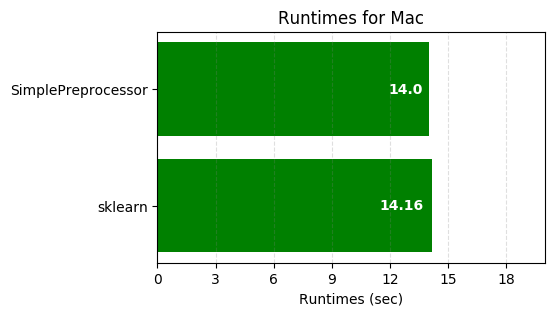

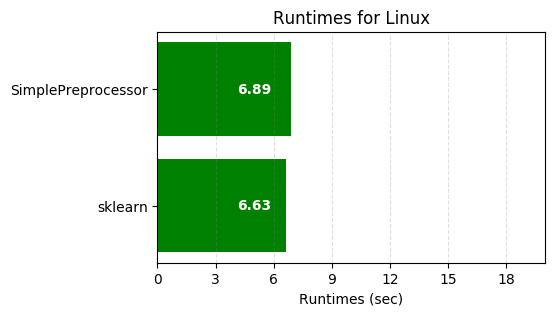

In [21]:
runtimeDict = {'SimplePreprocessor': round(simpleProcBoxMMean, 2), 
               'sklearn': round(sklearnBoxMMean, 2)}
plot_bar_chart('Runtimes for Mac', runtimeDict, [0, 20], 'Runtimes (sec)')

runtimeDict = {'SimplePreprocessor': round(simpleProcBoxLMean, 2), 
               'sklearn': round(sklearnBoxLMean, 2)}
plot_bar_chart('Runtimes for Linux', runtimeDict, [0, 20], 'Runtimes (sec)')

# plt.show()

#### Conclusion

On the Mac, SimplePreprocessor ran slightly faster than CountVectorizer. On the Linux machine, the reverse was true. So we can conclude that their runtime costs are the same.